# Notebook for Model Analysis 
This notebook is inteded to complement the medium article. 
The purpose is to assess the peformance of the finetuned models on the test data set.

Date 20/03/2023

### Data Scientist: John Adeojo https://www.john-adeojo.com/
### Linked in: https://www.linkedin.com/in/john-adeojo/
### Medium: https://johnadeojo.medium.com/
### Hugging Face: https://huggingface.co/Johnade

In [1]:
import pandas as pd
import numpy as np

# Read in Training, Test and Validation data 

In [2]:
test = r"C:\Users\johna\anaconda3\envs\twitter-analytics-env\twitter_issues_dashboard\twitter_issues_dashboard\data\03_feature_bank\test_df.csv"
train = r"C:\Users\johna\anaconda3\envs\twitter-analytics-env\twitter_issues_dashboard\twitter_issues_dashboard\data\03_feature_bank\train_df.csv"
validation = r"C:\Users\johna\anaconda3\envs\twitter-analytics-env\twitter_issues_dashboard\twitter_issues_dashboard\data\03_feature_bank\val_df.csv"

train_df = pd.read_csv(train)
val_df = pd.read_csv(validation)
test_df = pd.read_csv(test)

train_df = train_df[['cleaned_text', 'topic_hl']]
val_df = val_df[['cleaned_text', 'topic_hl']]
test_df = test_df[['cleaned_text', 'topic_hl']]
test_df['cat codes'] = test_df['topic_hl'].astype("category").cat.codes

In [3]:
test_df

,cleaned_text,topic_hl,cat codes
0,So excited to get this delivery from the posti...,Customer Service,0
1,#royalmail chief lost his job after #loosing ...,Customer Service,0
2,#RoyalMail are “in”,Customer Service,0
3,"Oh no a crappy, archaic service provider is pr...",Customer Service,0
4,Yesterday we got three items of junk mail - on...,Customer Service,0
...,...,...,...
520,#Investor revolt over #RoyalMail boss's pay de...,Politics,3
521,#RoyalMail in talks to permanently ditch Satur...,Customer Service,0
522,@RichardpanterH1 @lucyeyeington Totally agree ...,Customer Service,0
523,Royal Mail are taking the royal biscuit tbh,Customer Service,0


# Function for Running Inference

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


import re

def extract_values(x):
    # extract predicted class and probability from 'inference' column using regex pattern matching
    match = re.match(r"\[(.*?)\]", x["inference"])
    if match:
        predicted_class = match.group(1).split(",")[0].split(":")[1].strip().strip("'")
        prob = float(match.group(1).split(",")[1].split(":")[1].strip())
    else:
        predicted_class = ""
        prob = 0.0
    
    return pd.Series({"predicted_class": predicted_class, "prob": prob})




def perform_inference(df, MODEL, model_path):
    _df = df.copy()

    # load model
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    # Set up tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL)

    # set up pipeline
    classifier = pipeline(
        "text-classification", model=model, tokenizer=tokenizer, device=0
    )

    # perform inference and extract predicted class and probability
    _df["inference"] = classifier(list(df["cleaned_text"]), truncation=True)

    return _df



def plot_confusion_matrix_and_metrics(df, metrics_csv, confusion_png):
    # Extract ground truth labels and predicted labels
    y_true = df['topic_hl'].values
    y_pred = [inference['label'] for inference in df['inference'].values]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get unique labels
    labels = sorted(list(set(y_true) | set(y_pred)))

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(10, 10))
    sns_heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Save confusion matrix to a PNG file
    sns_heatmap.figure.savefig(confusion_png)
    plt.show()

    # Compute global metrics (accuracy)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # Compute class-level metrics (F1, precision, recall)
    class_report = classification_report(y_true, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()

    # Save class-level metrics to a CSV file
    class_report_df.to_csv(metrics_csv)

    print("\nClass-level Metrics (F1, Precision, Recall):")
    print(class_report_df)



C:\Users\johna\anaconda3\envs\twitter-analytics-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Run Inference

In [5]:
test_prediction_df = perform_inference(df=test_df, MODEL="cardiffnlp/twitter-roberta-base", model_path=r"C:\Users\johna\OneDrive\Desktop\models_twitter_dash\output")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


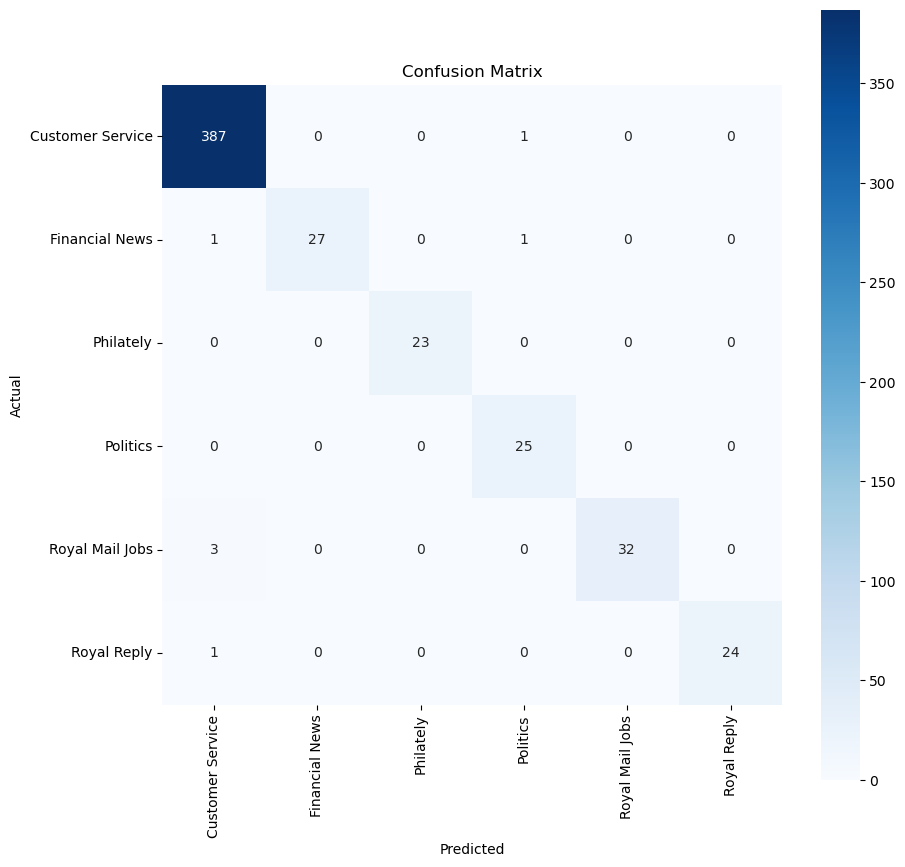

Accuracy: 0.99

Class-level Metrics (F1, Precision, Recall):
                  precision    recall  f1-score     support
Customer Service   0.987245  0.997423  0.992308  388.000000
Financial News     1.000000  0.931034  0.964286   29.000000
Philately          1.000000  1.000000  1.000000   23.000000
Politics           0.925926  1.000000  0.961538   25.000000
Royal Mail Jobs    1.000000  0.914286  0.955224   35.000000
Royal Reply        1.000000  0.960000  0.979592   25.000000
accuracy           0.986667  0.986667  0.986667    0.986667
macro avg          0.985528  0.967124  0.975491  525.000000
weighted avg       0.987046  0.986667  0.986554  525.000000


In [6]:
metrics_csv = r"C:\Users\johna\anaconda3\envs\twitter-analytics-env\twitter_issues_dashboard\twitter_issues_dashboard\data\05_Reports\metrics.csv"
confusion_png = r"C:\Users\johna\anaconda3\envs\twitter-analytics-env\twitter_issues_dashboard\twitter_issues_dashboard\data\05_Reports\confusion_matric.png"

plot_confusion_matrix_and_metrics(test_prediction_df, metrics_csv, confusion_png)

In [7]:
test_prediction_df.to_csv(r"C:\Users\johna\anaconda3\envs\twitter-analytics-env\twitter_issues_dashboard\twitter_issues_dashboard\data\04_model_output\testpred.csv")

# Model Convergence Plots

In [8]:
import requests
import json

def load_json_file(url):
    response = requests.get(url)
    json_obj = json.loads(response.text)
    return json_obj


def load_json_file_local(file_path):
    with open(file_path, 'r') as file:
        json_obj = json.load(file)
    return json_obj


In [9]:
# distilbert
filepath = r"C:\Users\johna\OneDrive\Desktop\models_twitter_dash\output\checkpoint-1000\trainer_state.json"
roberta = load_json_file_local(filepath)


In [10]:
def plot_eval_loss(json_obj, title):
    # Extract the data for the plot
    eval_loss = [entry['eval_loss'] for entry in json_obj['log_history'] if 'eval_loss' in entry]
    train_loss = [entry['loss'] for entry in json_obj['log_history'] if 'loss' in entry]

    step = [entry['step'] for entry in json_obj['log_history'] if 'eval_loss' in entry]
    
    # Create the plot using Seaborn
    sns.set_style("darkgrid")
    plt.plot(step, eval_loss, label='Evaluation Loss')
    plt.plot(step, train_loss, label='Training Loss')
    plt.title(f'Evaluation and Training Loss vs Step: {title}')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(r"C:\Users\johna\anaconda3\envs\twitter-analytics-env\twitter_issues_dashboard\twitter_issues_dashboard\data\05_Reports\model_convergence.png")
    plt.show()


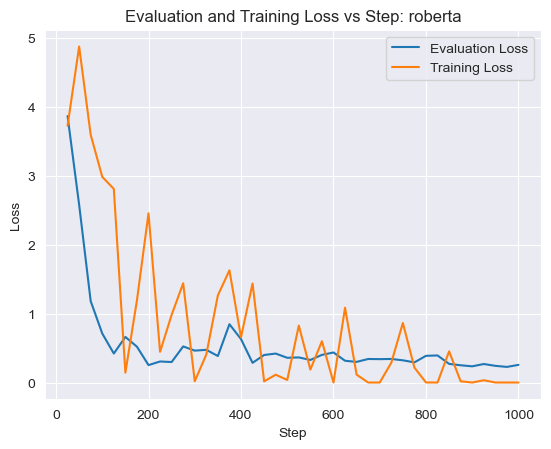

In [11]:
plot_eval_loss(roberta, title="roberta")